<a href="https://colab.research.google.com/github/giacomogreggio/computer-vision-project/blob/master/Image_segmentation_with_FCN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Checking GPU Enabled

In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


#Importing Libraries

In [2]:
import math
import numpy as np
import keras
import cv2
import scipy.io
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Input, MaxPool2D, ZeroPadding2D, Cropping2D, Softmax, Add, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.utils import Sequence

from IPython.display import clear_output
import matplotlib.pyplot as plt

# Downloading the Dataset

In [3]:
from google.colab import drive
import os
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
4/4AFNxAvVEYQfOQU7O1kdkod3g9knE5teMoswydoaUIIk1yi4Re0Oyi8
Mounted at /content/drive


In [5]:
if "img8k" not in os.listdir("/content"):
  !unzip "/content/drive/My Drive/VOC/images.zip"
if "mask8k" not in os.listdir("/content"):
  !unzip "/content/drive/My Drive/VOC/masks.zip"

In [6]:
TRAIN_FILE_NAMES=open("/content/drive/My Drive/VOC/train.txt").read().split()
VAL_FILE_NAMES=open("/content/drive/My Drive/VOC/val.txt").read().split()

In [7]:
def normalize(input_image):
    mean=(122.67891434, 116.66876762, 104.00698793)
    return input_image - mean

In [8]:
def open_image(name, path):
    with open(path + '/' + name+".npy", 'rb') as f:
        return np.load(f) 

#Important Hyperparameters

In [9]:
IMAGE_SHAPE=(None,None,3)
N_CLASSES=21
L2_VALUE=5**-4

BATCH_SIZE = 1
EPOCHS = 500
VAL_SUBSPLITS = 5

DATASET_PATH = "/content"

IMAGE_PATH = DATASET_PATH + '/img8k'
MASK_PATH = DATASET_PATH + '/mask8k'

TRAIN_LENGTH = len(TRAIN_FILE_NAMES)
VALIDATION_STEPS = len(VAL_FILE_NAMES)//BATCH_SIZE//VAL_SUBSPLITS
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

# Taking a look at the dataset

In [10]:
def print_img(img):
    plt.figure(figsize=(14, 7))
    plt.subplot(1,1,1), plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)), plt.title('Lena'), plt.axis('off')
    
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']
    if (len(display_list)>1 and len(display_list[1].shape)==2):
      display_list[1] = np.expand_dims(display_list[1],axis=2)
    

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()
    
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]


def show_predictions(model, num=1):
    for i in range(num if num < len(example_images) else len(example_images)):  
        pred_mask = create_mask(model(np.expand_dims(example_images[i],axis=0)))
        display([example_images[i], example_masks[i], pred_mask])

In [11]:
number_of_examples = 10

example_images = []
example_masks = []
for i, img_id in enumerate(VAL_FILE_NAMES):
    example_images.append(normalize(open_image(img_id, IMAGE_PATH)))
    example_masks.append(open_image(img_id, MASK_PATH))
    
    if i==number_of_examples:
        break

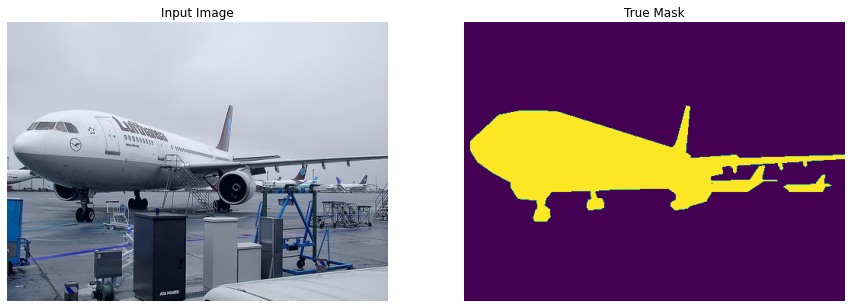

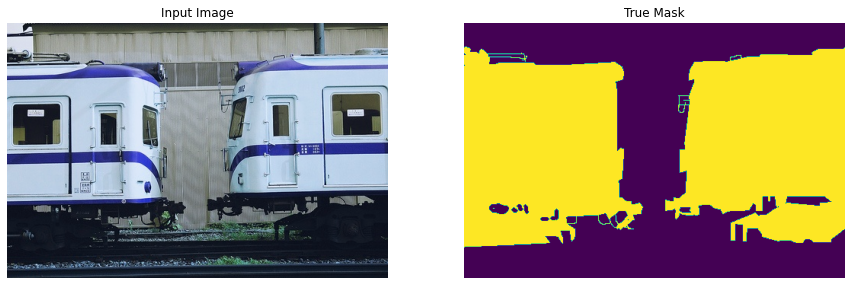

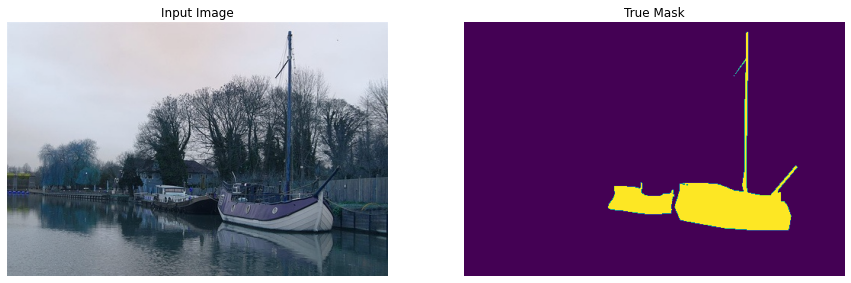

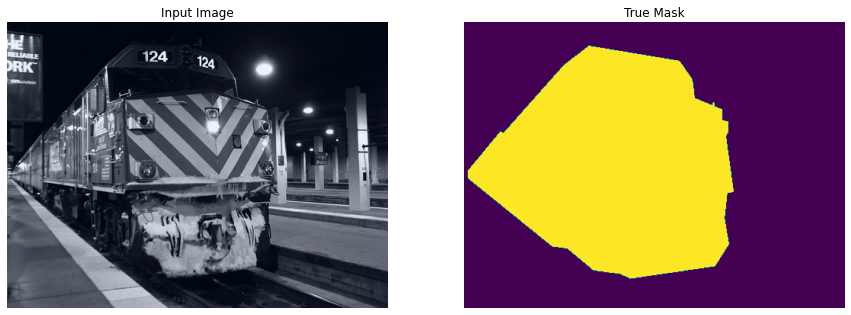

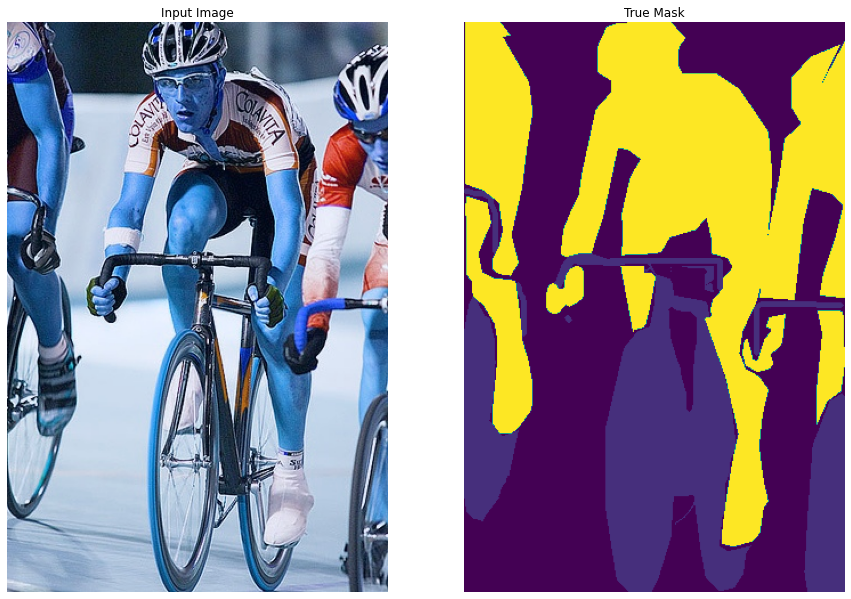

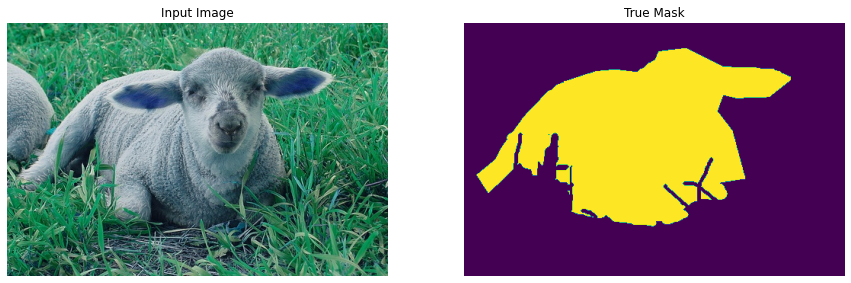

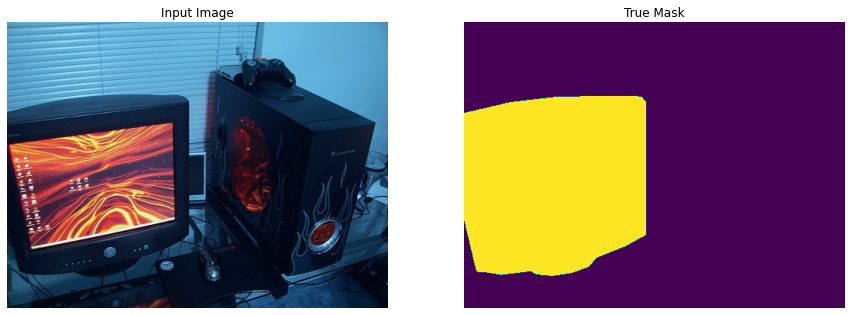

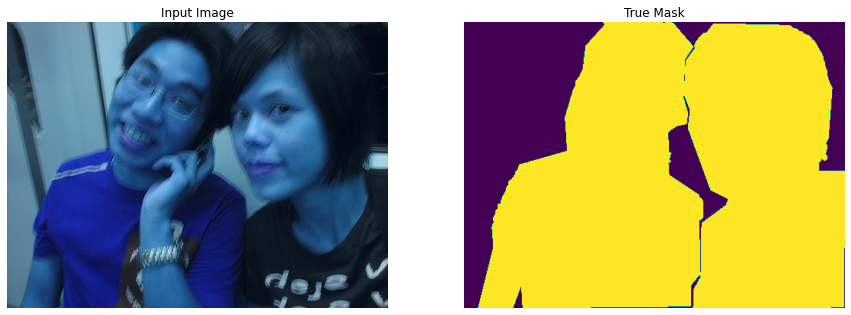

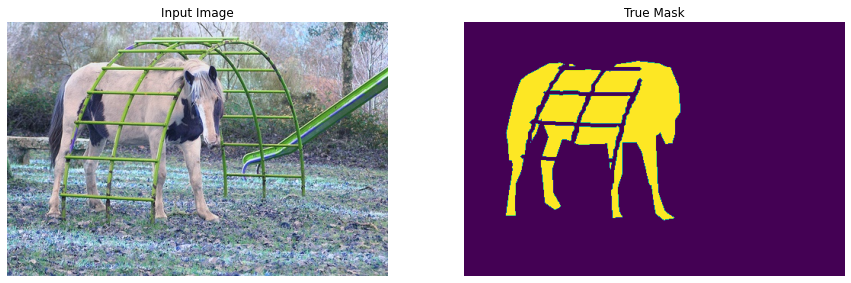

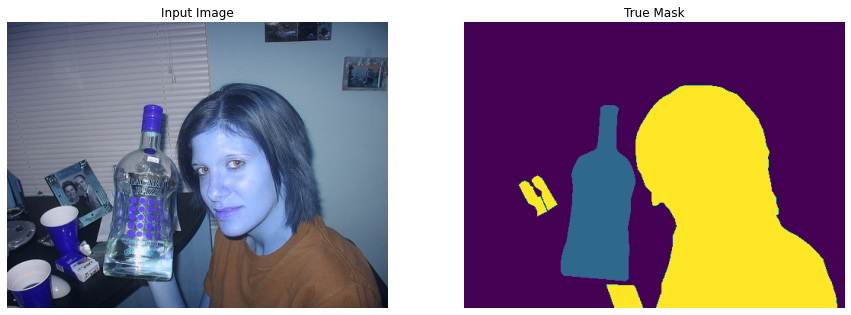

In [12]:
for i in range(number_of_examples):
    display([example_images[i], example_masks[i]])

# Defining the models

In [13]:
class Crop(tf.keras.layers.Layer):
  def call(self, inputs):
    x1, x2 = inputs
    x1_shape = tf.shape(x1)
    x2_shape = tf.shape(x2)
    # offsets for the top left corner of the crop
    offsets = [0, (x1_shape[1] - x2_shape[1]) // 2, (x1_shape[2] - x2_shape[2]) // 2, 0]
    size = [-1, x2_shape[1], x2_shape[2], -1]
    x1_crop = tf.slice(x1, offsets, size)
    return x1_crop

## Base Vgg Architecture

In [14]:
def create_base_vgg(trainable=True):
  tf.keras.backend.clear_session()
  #Defining Base VGG architecture
  input_layer = Input(shape=IMAGE_SHAPE, name="input")
  #VGG-block1
  b1 = Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu", name="conv2d_b1_1")(input_layer)
  b1 = Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu", name="conv2d_b1_2")(b1)
  b1 = MaxPool2D(pool_size=(2,2),strides=(2,2), name="maxpool_b1")(b1)

  #VGG-block2
  b2 = Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu", name="conv2d_b2_1")(b1)
  b2 = Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu", name="conv2d_b2_2")(b2)
  b2 = MaxPool2D(pool_size=(2,2),strides=(2,2), name="maxpool_b2")(b2)

  #VGG-block3
  b3 = Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu", name="conv2d_b3_1")(b2)
  b3 = Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu", name="conv2d_b3_2")(b3)
  b3 = Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu", name="conv2d_b3_3")(b3)
  b3 = MaxPool2D(pool_size=(2,2),strides=(2,2), name="maxpool_b3")(b3)

  #VGG-block4
  b4 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu", name="conv2d_b4_1")(b3)
  b4 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu", name="conv2d_b4_2")(b4)
  b4 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu", name="conv2d_b4_3")(b4)
  b4 = MaxPool2D(pool_size=(2,2),strides=(2,2), name="maxpool_b4")(b4)

  #VGG-block5
  b5 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu", name="conv2d_b5_1")(b4)
  b5 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu", name="conv2d_b5_2")(b5)
  b5 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu", name="conv2d_b5_3")(b5)
  b5 = MaxPool2D(pool_size=(2,2),strides=(2,2), name="maxpool_b5")(b5)

  vgg_model = Model(input_layer, b5)
  vgg16= VGG16(weights="imagenet", include_top=False)
  vgg16.save_weights("./weights.h5")
  vgg_model.load_weights("./weights.h5")
  vgg_model.trainable=trainable

  return vgg_model

## FCN-32

In [15]:
def create_fcn32(vgg_trainable=True, include_top=True):
  vgg_model=create_base_vgg(trainable=vgg_trainable)
  b5=vgg_model.layers[-1].output
  input_layer=vgg_model.layers[0].output
  fcn_32_block = Conv2D(4096, kernel_size=(7,7), activation='relu', padding="same", name="conv2d_fcn32_1")(b5)
  fcn_32_block = Dropout(0.5, name="dropout_fcn32_1")(fcn_32_block)
  fcn_32_block = Conv2D(4096, kernel_size=(1,1), activation='relu', padding="same", name="conv2d_fcn32_2")(fcn_32_block)
  fcn_32_block = Dropout(0.5, name="dropout_fcn32_2")(fcn_32_block)
  fcn_32_block = Conv2D(N_CLASSES, kernel_size=(1,1), padding="same",kernel_initializer='he_normal', name="conv2d_fcn32_3")(fcn_32_block)
  if include_top:
    fcn_32_transpose = Conv2DTranspose(N_CLASSES, kernel_size=(64,64), strides=(32,32), use_bias=False, name="deconv_fcn32")(fcn_32_block)
    fcn_32_crop = Crop()([fcn_32_transpose, input_layer])
    fcn_32_softmax=Softmax(name="softmax_fcn32")(fcn_32_crop)
    return Model(input_layer, fcn_32_softmax)
  else:
    return Model(input_layer, fcn_32_block)

##FCN-16

In [16]:
def create_fcn16(vgg_trainable=True, include_top=True):#, kernel_regularizer=l2(L2_VALUE)
  fcn_32=create_fcn32(vgg_trainable=vgg_trainable, include_top=False)
  input_layer=fcn_32.layers[0].output
  b4=fcn_32.get_layer("maxpool_b4").output
  fcn_32_block=fcn_32.layers[-1].output

  fcn_16_block_fcn32 = Conv2DTranspose(N_CLASSES, kernel_size=(4,4), padding="valid", strides=(2,2), use_bias=False, name="deconv_fcn16_1")(fcn_32_block)
  fcn_16_block = Conv2D(N_CLASSES, kernel_size=(1,1), activation="relu", padding="valid", kernel_initializer='he_normal', name="conv2d_fcn16_1")(b4)

  fcn_16_block_fcn32 = Crop()([fcn_16_block_fcn32,fcn_16_block])

  fcn_16_block = Add(name="add_fcn16")([fcn_16_block_fcn32,fcn_16_block])

  if include_top:
    fcn_16_deconv = Conv2DTranspose(N_CLASSES, kernel_size=(32,32), strides=(16,16), use_bias=False, name="deconv_fcn16_2")(fcn_16_block)
    fcn_16_crop = Crop()([fcn_16_deconv,input_layer])
    fcn_16_softmax=Softmax(name="softmax_fcn16")(fcn_16_crop)
    return Model(input_layer, fcn_16_softmax)
  else:
    return Model(input_layer, fcn_16_block)

##FCN-8

In [17]:
def create_fcn8(vgg_trainable=True, include_top=True):
  fcn_16=create_fcn16(vgg_trainable=vgg_trainable, include_top=False)
  input_layer=fcn_16.layers[0].output
  b3=fcn_16.get_layer("maxpool_b3").output
  fcn_16_block=fcn_16.layers[-1].output

  fcn_8_block_fcn16 = Conv2DTranspose(N_CLASSES, kernel_size=(4,4), padding="valid", strides=(2,2), use_bias=False, name="deconv_fnc8_1")(fcn_16_block)
  fcn_8_block = Conv2D(N_CLASSES, kernel_size=(1,1), activation="relu", padding="valid", kernel_initializer='he_normal', name="conv2d_fcn8_1")(b3)
  
  fcn_8_block_fcn16 = Crop()([fcn_8_block_fcn16,fcn_8_block])
  
  fcn_8_block = Add(name="add_fcn8")([fcn_8_block_fcn16,fcn_8_block])

  if include_top:
    fcn_8_deconv = Conv2DTranspose(N_CLASSES, kernel_size=(16,16), strides=(8,8), use_bias=False, name="deconv_fnc8_2")(fcn_8_block)
    fcn_8_crop = Crop()([fcn_8_deconv,input_layer])
    fcn_8_softmax=Softmax(name="softmax_fcn8")(fcn_8_crop)
    return Model(input_layer, fcn_8_softmax)
  else:
    return Model(input_layer, fcn_8_block)

#Training the model

##Defining Useful Callbacks

In [20]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def __init__(self,model):
    self.model=model
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions(self.model)
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

##Defining custom mean_iou metric

In [21]:
class AdaptedMeanIoU(tf.keras.metrics.Metric):
  def __init__(self, name='mean_iou', n_classes=3,**kwargs):
    super(AdaptedMeanIoU, self).__init__(name=name, **kwargs)
    self.mean_iou=MeanIoU(n_classes)

  def update_state(self, y_true, y_pred, sample_weight=None):
    
    y_pred_converted=tf.argmax(y_pred,axis=-1)
    self.mean_iou.update_state(y_true,y_pred_converted)
  def result(self):
    return self.mean_iou.result()
  def reset_states(self):
    self.mean_iou.reset_states()

## Data Generator

In [23]:
class DataGenerator(Sequence):
    def __init__(self, list_IDs, image_path, mask_path, to_fit=True, batch_size=32, shuffle=True):
        self.list_IDs = list_IDs
        self.image_path=image_path
        self.mask_path=mask_path
        self.to_fit = to_fit
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        X = self._generate_X(list_IDs_temp)

        if self.to_fit:
            y = self._generate_y(list_IDs_temp)
            return X, y
        else:
            return X

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def _generate_X(self, list_IDs_temp):
        X = []
        for i, ID in enumerate(list_IDs_temp):
            train_img=open_image(ID, self.image_path)
            X.append(normalize(train_img))

            #X.append(train_img)
        return np.array(X)

    def _generate_y(self, list_IDs_temp):
        y = []
        for i, ID in enumerate(list_IDs_temp):
            y.append(open_image(ID, self.mask_path))
        return np.array(y)

## Defining a function to load the weights

In [24]:
def best_weights_loading(model, name):
    if "best_val_iou_fcn"+ name + "_model_weights.h5" in os.listdir("/content/drive/My Drive/VOC/checkpoints"):
        model.load_weights("/content/drive/My Drive/VOC/checkpoints/best_val_iou_fcn"+ name + "_model_weights.h5")
        print("Weights loaded")
    else:
        print("Weights not loaded")

## Defining useful functions to save losses and show results

In [25]:
def print_losses(loss, val_loss, iou, val_iou):
    
    epochs = range(len(loss))

    ymax = np.max(val_iou)
    xmax = np.argmax(val_iou)
    f = plt.figure(figsize=(15, 5))

    ax1 = f.add_subplot(121)
    ax2 = f.add_subplot(122)

    ax1.plot(epochs, loss, 'r', label='Training loss')
    ax1.plot(epochs, val_loss, 'g', label='Validation loss')
    ax1.set_title('Training and Validation loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss Value')
    ax1.set_ylim([0,2])
    ax1.grid(True)
    ax1.legend()

    ax2.plot(epochs, iou, 'r', label='Training iou')
    ax2.plot(epochs, val_iou, 'g', label='Validation iou')
    ax2.set_title('Training and Validation iou')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('iou Value')
    ax2.set_ylim([0,1])
    ax2.grid(True)
    ax2.set_yticks([0.05*i for i in range(21)])
    ax2.text(xmax, ymax+0.03, "Max: " +str('%.3f'%(ymax)), transform=ax2.transData)
    ax2.legend()
    plt.show()


class save_losses(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        path = "/content/drive/My Drive/VOC/results"
        if "losses"+ actual_model + ".npy" in os.listdir(path):
            with open(path + "/losses"+ actual_model + ".npy", 'rb') as f:
                a = np.load(f).tolist()
                prev_loss, prev_val_loss, prev_iou, prev_val_iou = a[0], a[1], a[2], a[3]
        else:
            prev_loss, prev_val_loss, prev_iou, prev_val_iou = [], [], [], []

        if len(prev_val_iou) == 0 or logs['val_mean_iou'] > np.max(prev_val_iou):
            if len(prev_val_iou) > 0:
                print("Val iou increases from {} to {}. Saving model".format(np.max(prev_val_iou), logs['val_mean_iou']))
            else:
                print("Saving model")
            self.model.save_weights("/content/drive/My Drive/VOC/checkpoints/best_val_iou_fcn" + actual_model + "_model_weights.h5")

        prev_loss.append(logs['loss'])
        prev_val_loss.append(logs['val_loss'])
        prev_iou.append(logs['mean_iou'])
        prev_val_iou.append(logs['val_mean_iou'])
        print_losses(prev_loss, prev_val_loss, prev_iou, prev_val_iou)
        res = [np.array(prev_loss), np.array(prev_val_loss), np.array(prev_iou), np.array(prev_val_iou)]
        np.save(path + "/losses"+ actual_model + ".npy", np.array(res))

## Execute Training
### Defining a function to train a model


In [26]:
def train(model, name):
    generator_train = DataGenerator(TRAIN_FILE_NAMES, image_path=IMAGE_PATH, mask_path=MASK_PATH,
                          to_fit=True, batch_size=BATCH_SIZE,shuffle=True)
    generator_val = DataGenerator(VAL_FILE_NAMES, image_path=IMAGE_PATH, mask_path=MASK_PATH,
                            to_fit=True, batch_size=BATCH_SIZE,shuffle=True)
    callbacks=[
        keras.callbacks.EarlyStopping(patience=10, monitor="loss", verbose=2),
        keras.callbacks.ModelCheckpoint("/content/drive/My Drive/VOC/checkpoints/best_fcn"+ name + "_model_weights.h5", save_best_only=True, verbose=1, save_only_weights=True, monitor="loss"),
        tf.keras.callbacks.CSVLogger("/content/drive/My Drive/VOC/results/fcn"+ name + "_results.csv", separator=";", append=True),
        DisplayCallback(model),
        save_losses()
    ]
    model_history = model.fit(generator_train, epochs=EPOCHS,
                            steps_per_epoch=STEPS_PER_EPOCH,
                            validation_steps=VALIDATION_STEPS,
                            callbacks=callbacks, 
                            validation_data=generator_val)
    return model_history

### Training FCN8

58892288/58889256 [==============================] - 1s 0us/step


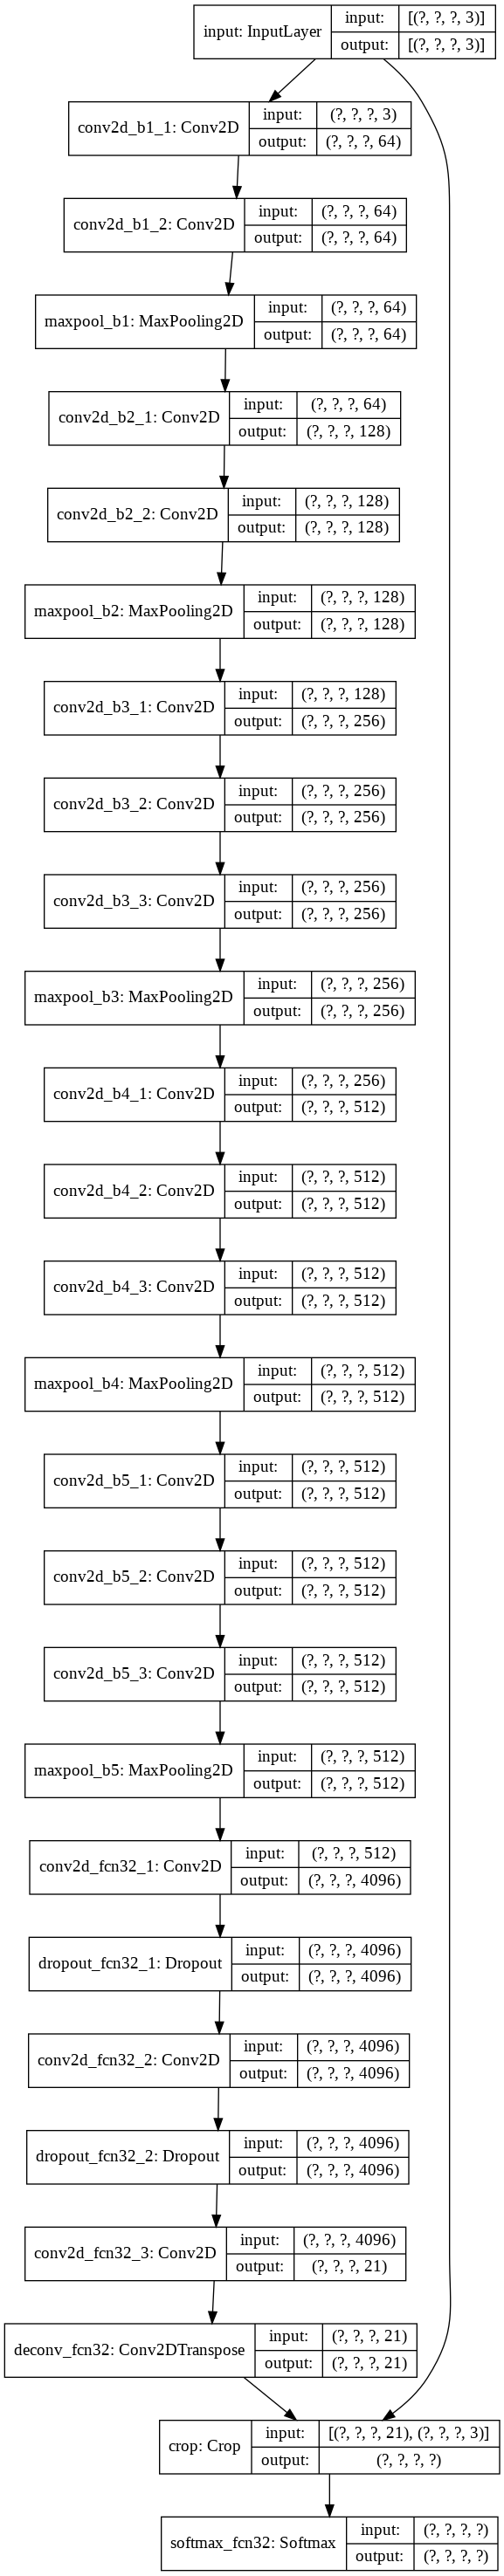

In [27]:
fcn32_model=create_fcn32()
fcn32_model.compile(optimizer=SGD(learning_rate=0.0001, momentum=0.99, nesterov=True, clipnorm=True), loss=SparseCategoricalCrossentropy(), metrics=[AdaptedMeanIoU(n_classes=N_CLASSES)])
actual_model = "32" 
tf.keras.utils.plot_model(fcn32_model, show_shapes=True)

In [ ]:
#train(fcn32_model, actual_model)

Weights loaded


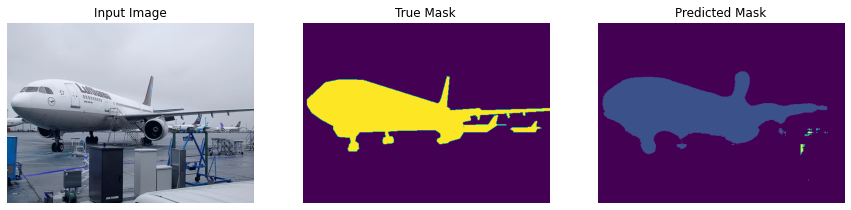

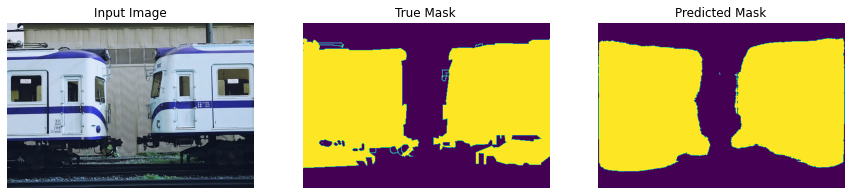

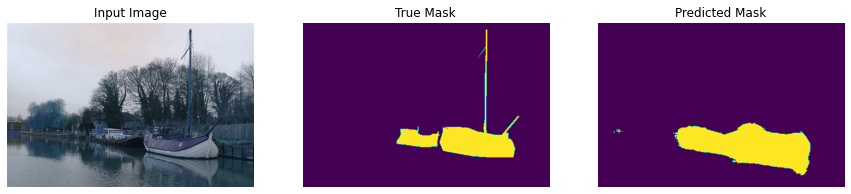

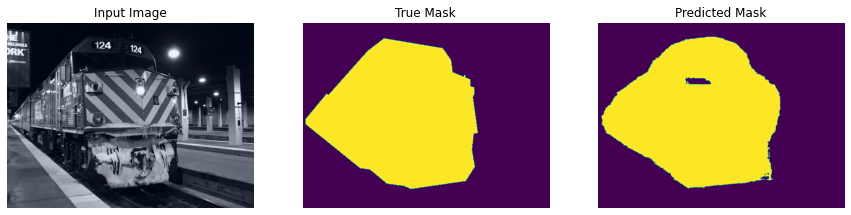

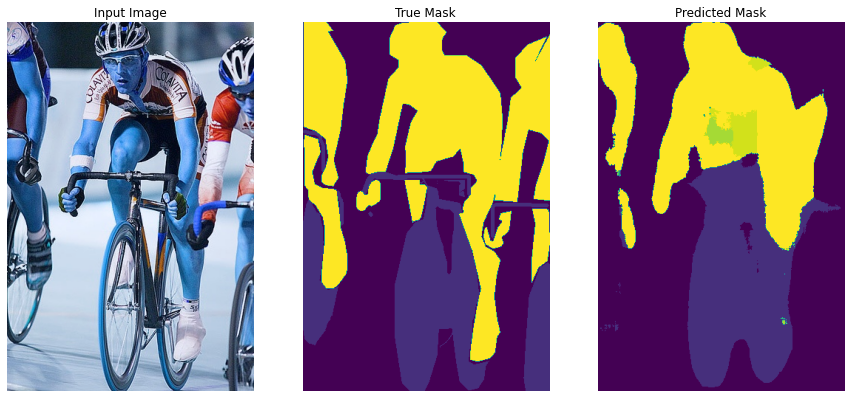

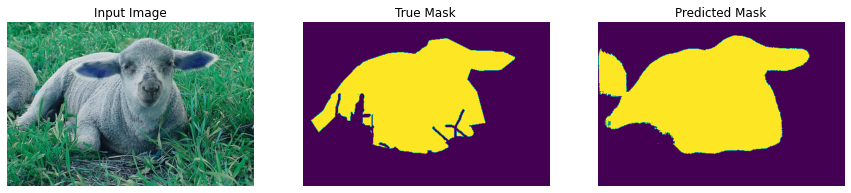

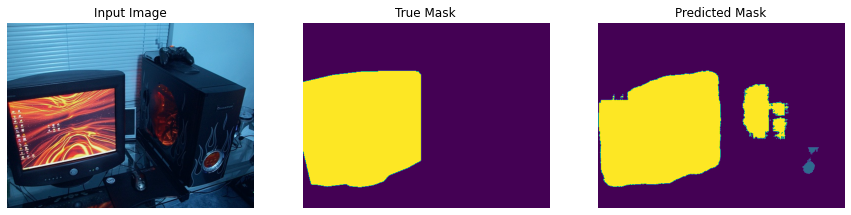

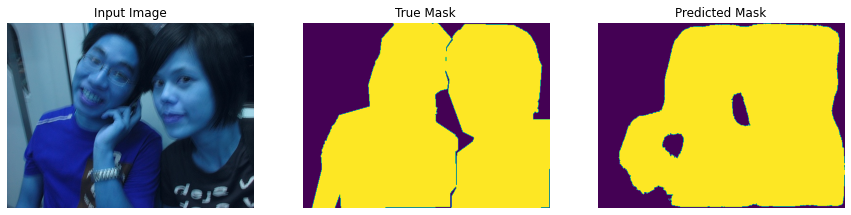

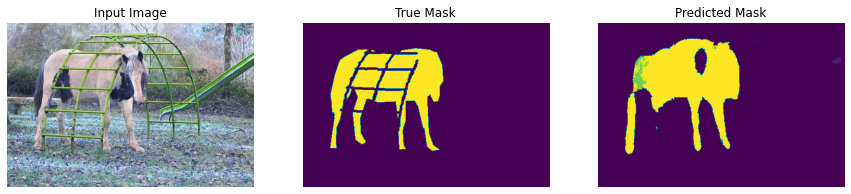

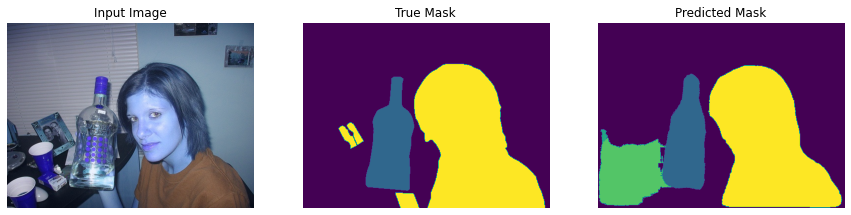

In [28]:
best_weights_loading(fcn32_model, actual_model)
show_predictions(fcn32_model,10)

### Training FCN16

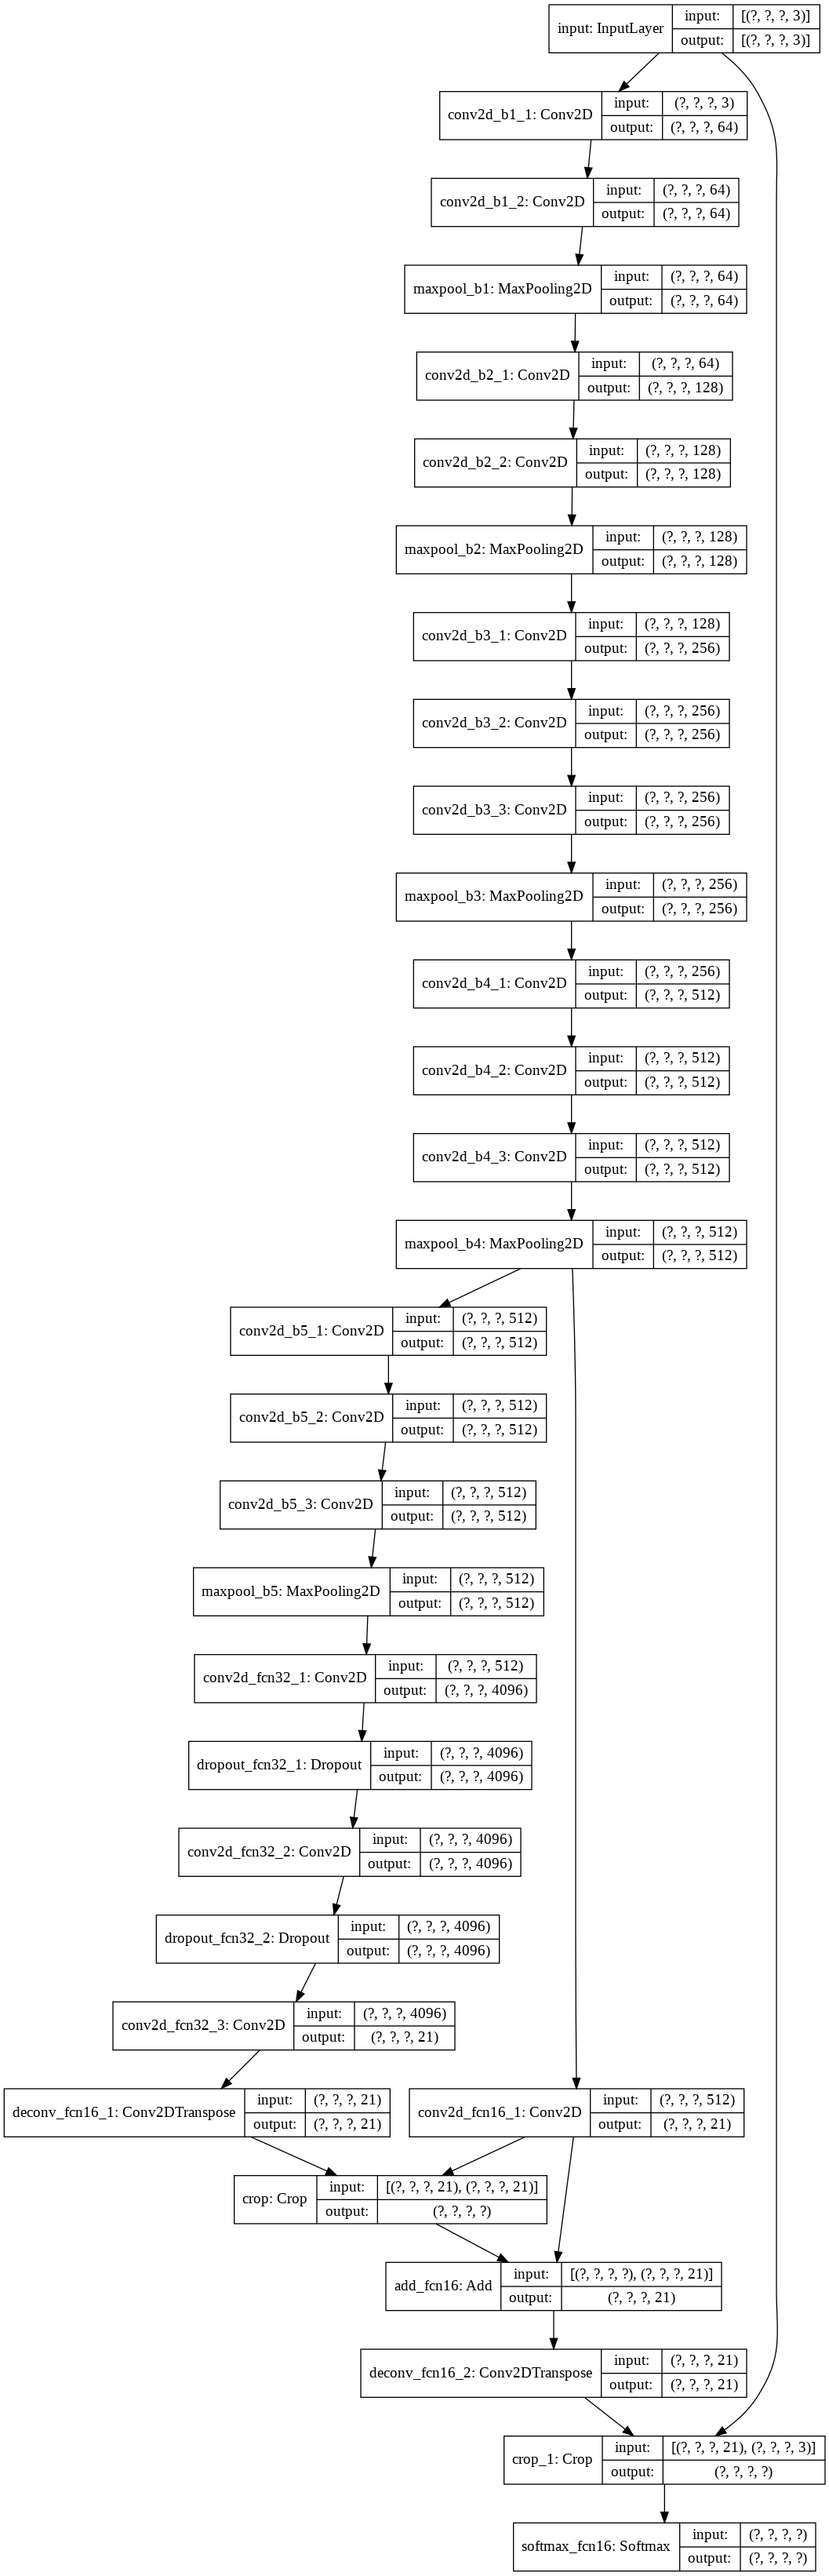

In [29]:
fcn16_model=create_fcn16()
fcn16_model.compile(optimizer=SGD(learning_rate=0.0001, momentum=0.99, nesterov=True, clipnorm=True), loss=SparseCategoricalCrossentropy(), metrics=[AdaptedMeanIoU(n_classes=N_CLASSES)])
actual_model = "16" 
tf.keras.utils.plot_model(fcn16_model, show_shapes=True)

In [30]:
#train(fcn16_model, actual_model)

Weights loaded


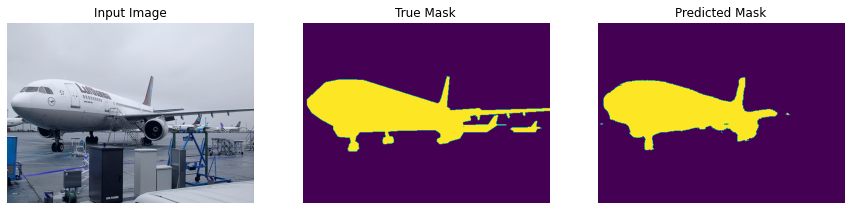

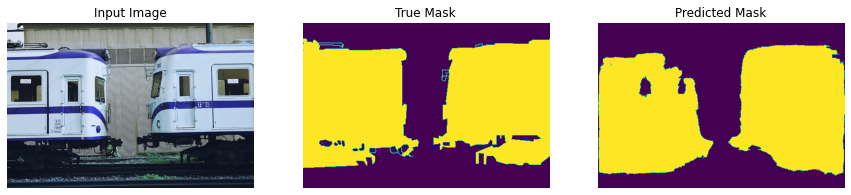

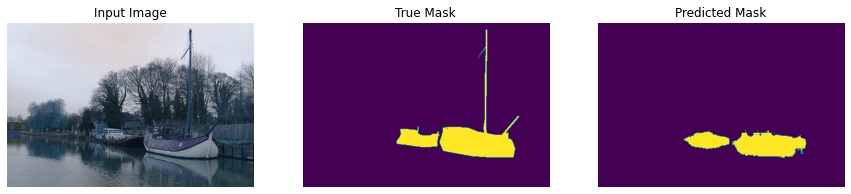

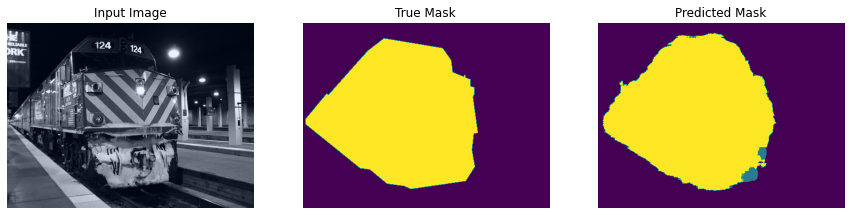

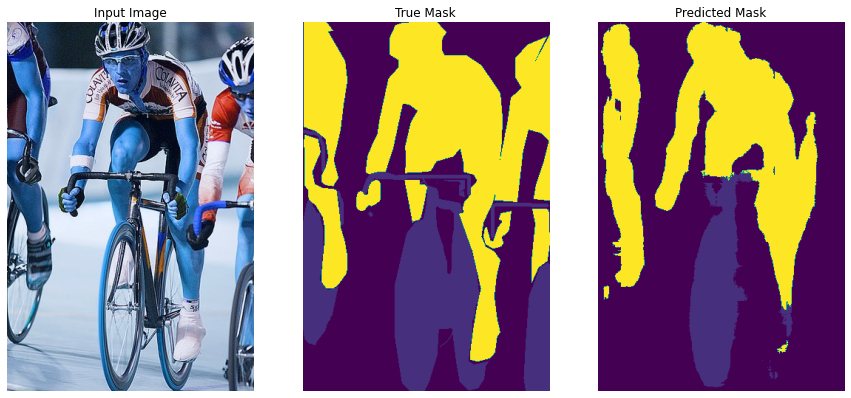

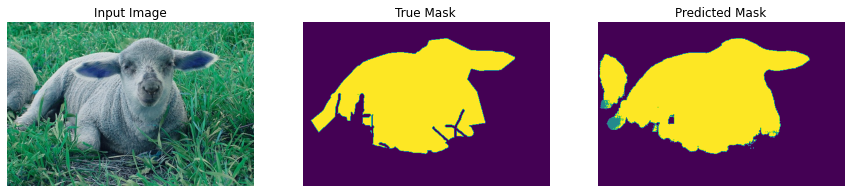

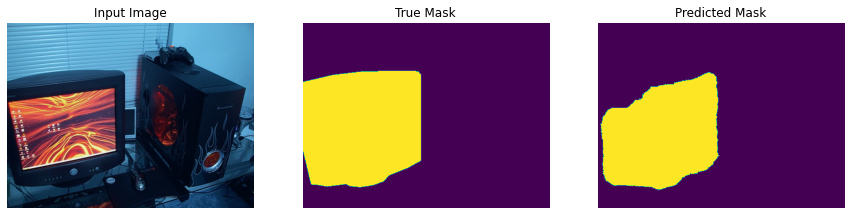

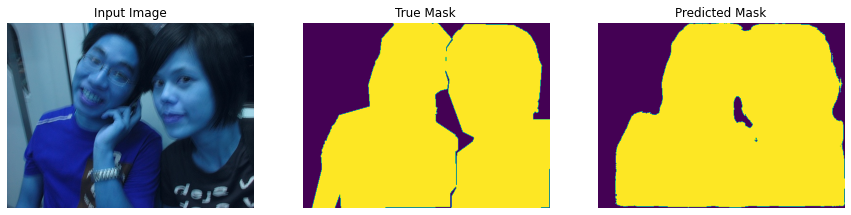

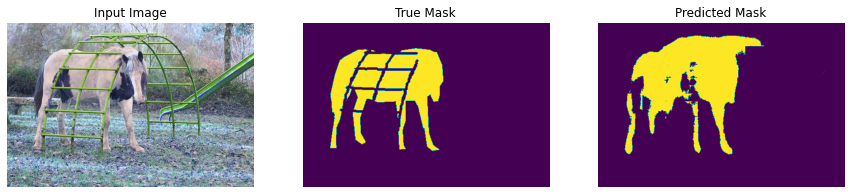

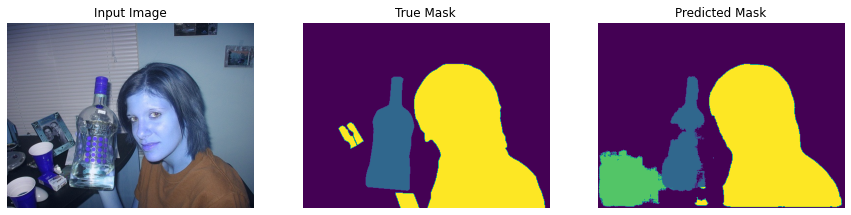

In [31]:
best_weights_loading(fcn16_model, actual_model)
show_predictions(fcn16_model, 10)

### Training FCN16

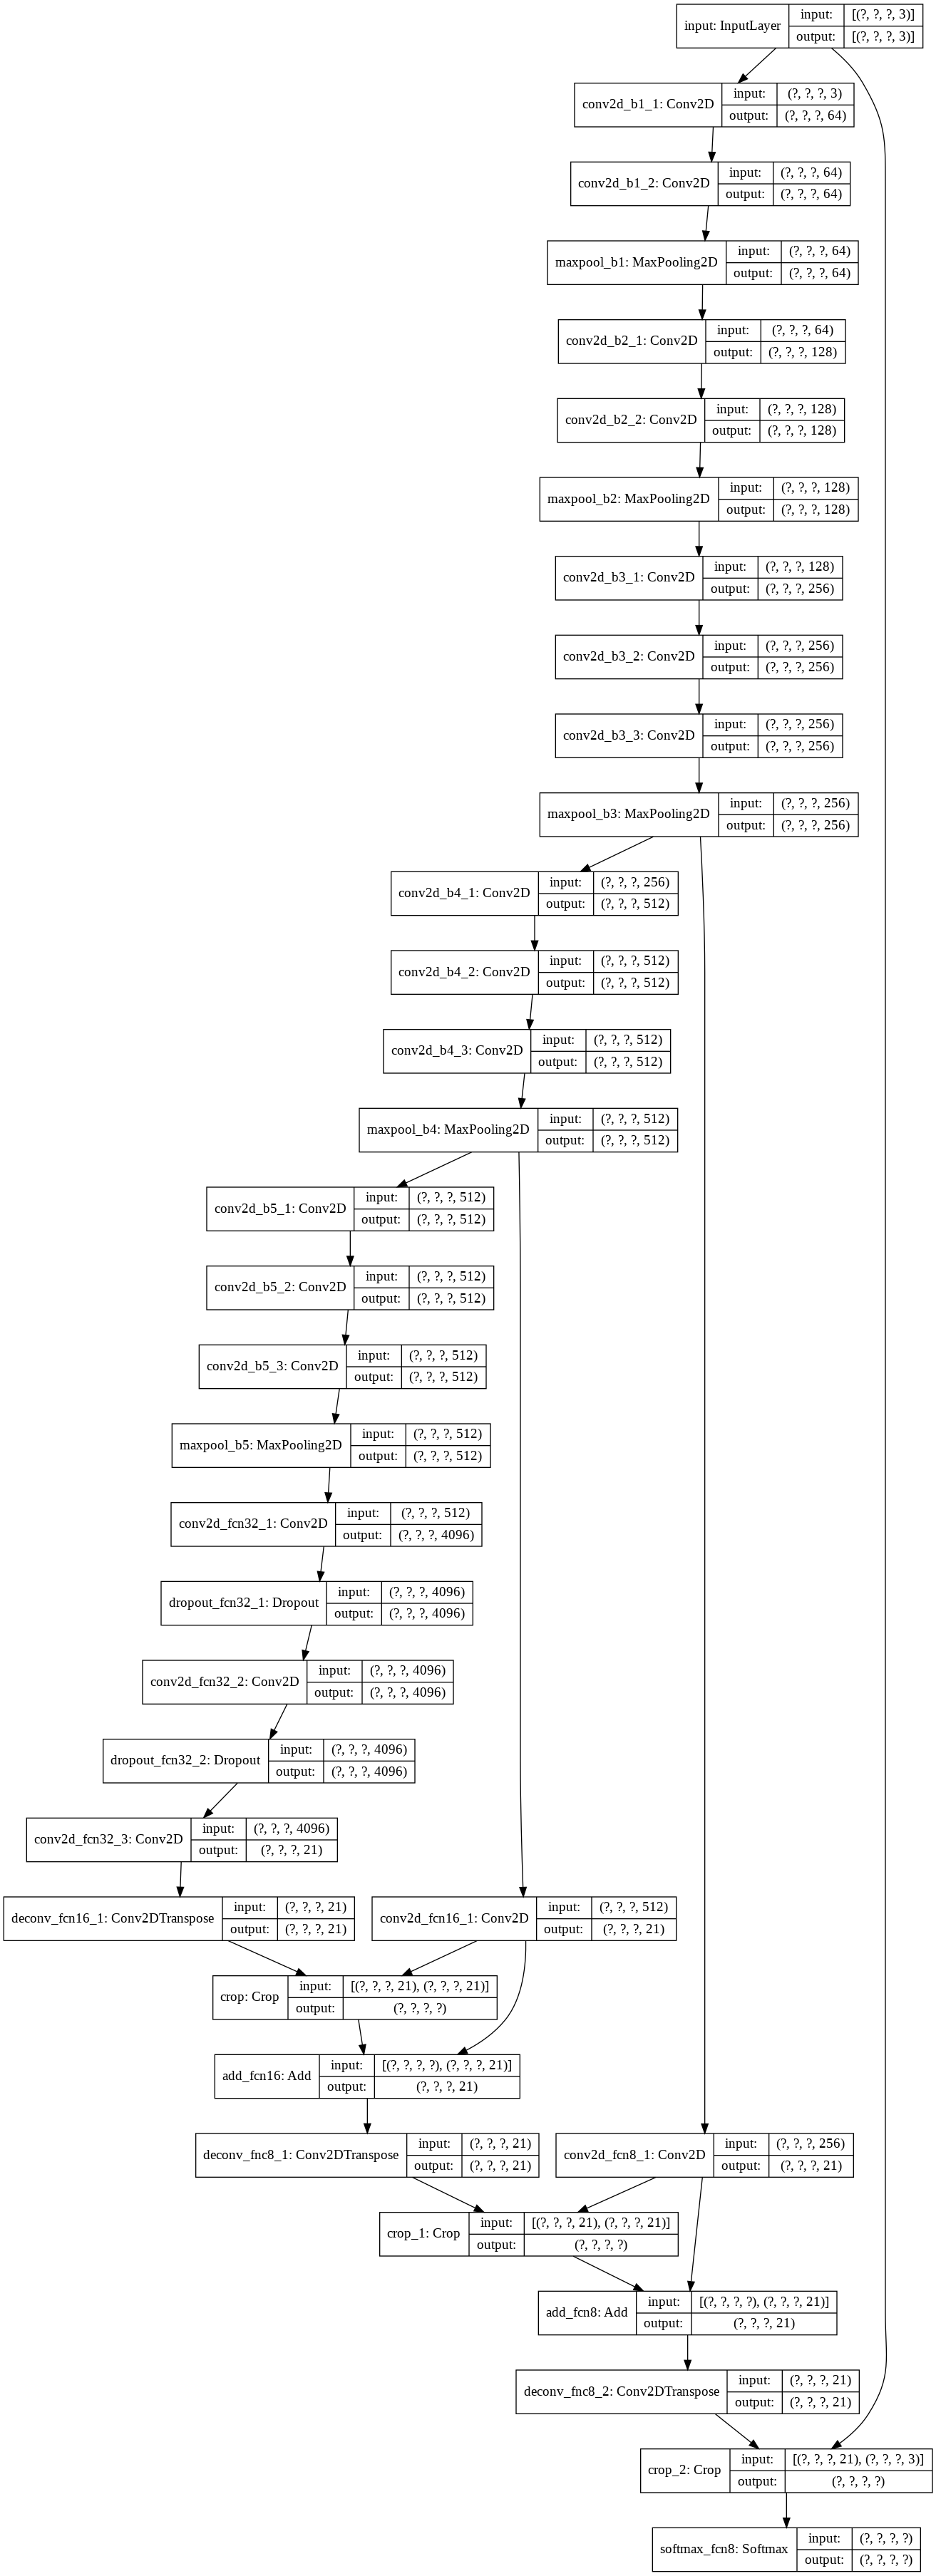

In [32]:
fcn8_model=create_fcn8()
fcn8_model.compile(optimizer=SGD(learning_rate=0.0001, momentum=0.99, nesterov=True, clipnorm=True), loss=SparseCategoricalCrossentropy(), metrics=[AdaptedMeanIoU(n_classes=N_CLASSES)])
actual_model = "8" 
tf.keras.utils.plot_model(fcn8_model, show_shapes=True)

In [33]:
#train(fcn8_model, actual_model)

Weights loaded


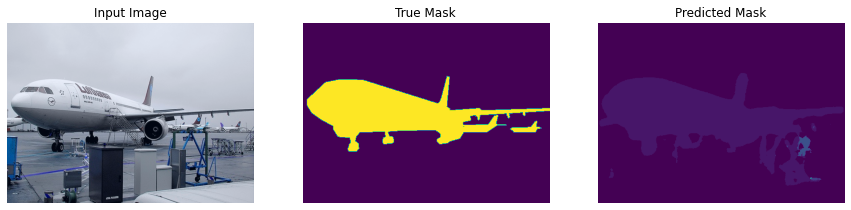

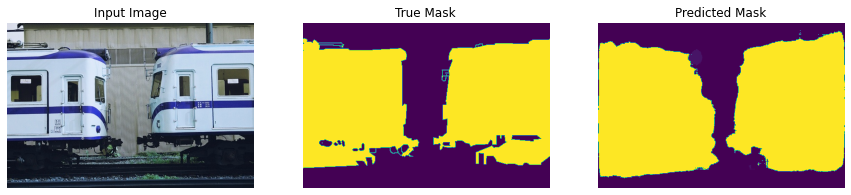

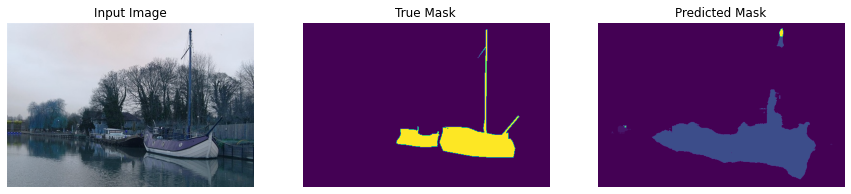

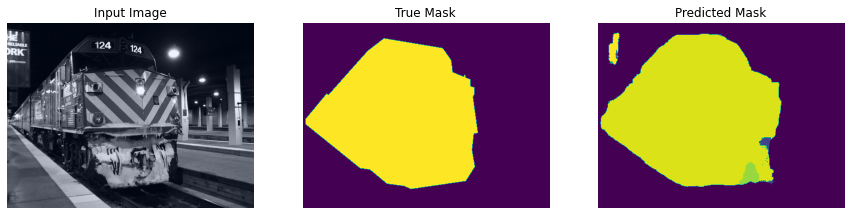

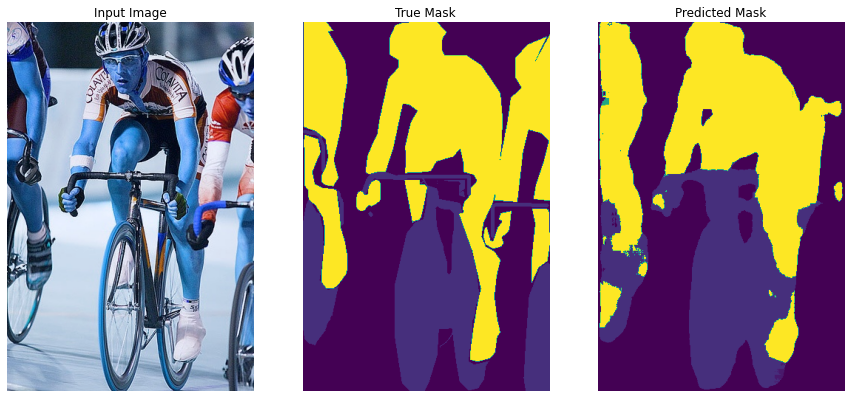

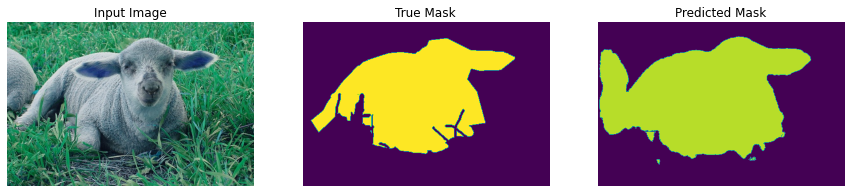

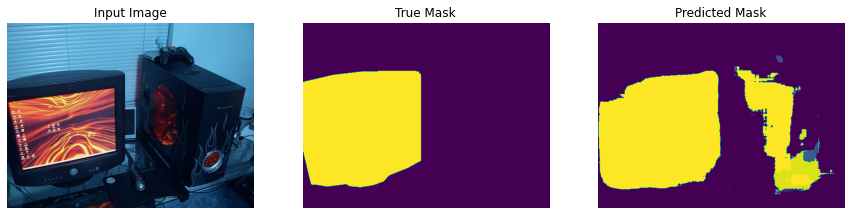

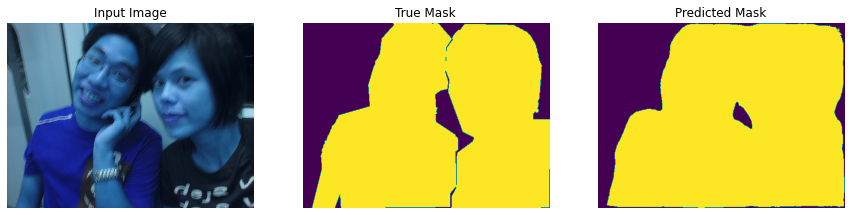

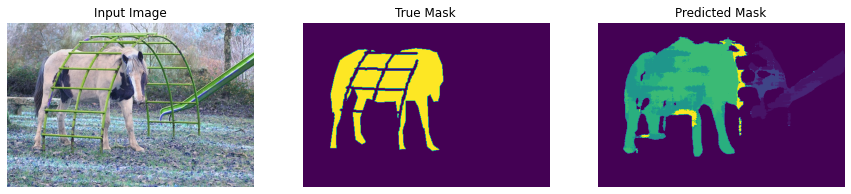

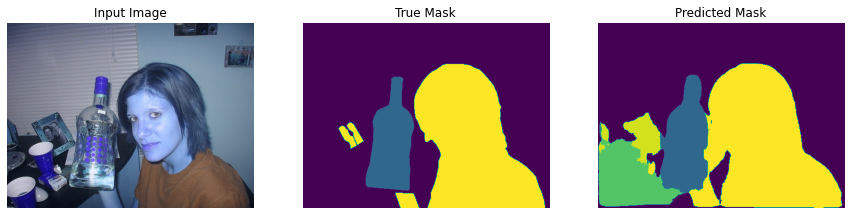

In [34]:
best_weights_loading(fcn8_model, actual_model)
show_predictions(fcn8_model, 10)

## Function to load losses and meanIU and show them

In [35]:
def show_losses(name):
    path = "/content/drive/My Drive/VOC/results"
    with open(path + "/losses"+ name + ".npy", 'rb') as f:
        a = np.load(f).tolist()
        prev_loss, prev_val_loss, prev_iou, prev_val_iou = a[0], a[1], a[2], a[3]
    print_losses(prev_loss, prev_val_loss, prev_iou, prev_val_iou)

#### FCN32 losses and meanIU

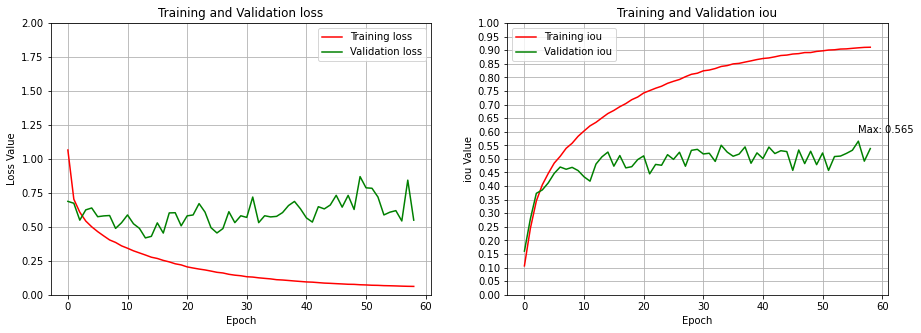

In [36]:
show_losses("32")

#### FCN16 losses and meanIU

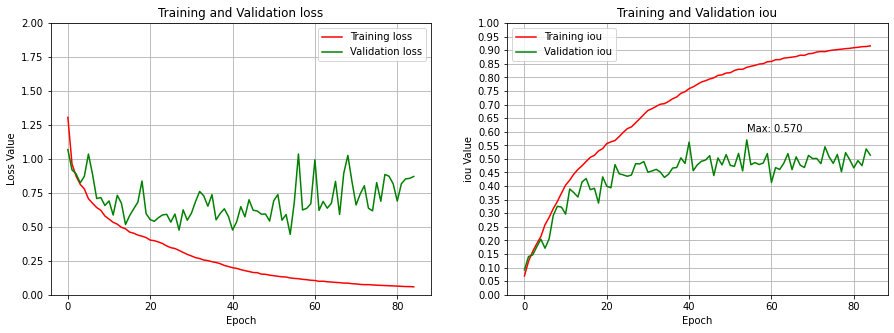

In [37]:
show_losses("16")

#### FCN8 losses and meanIU

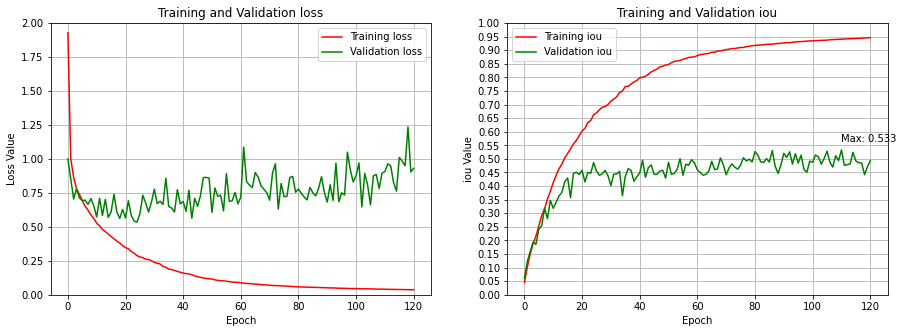

In [38]:
show_losses("8")